# Лабораторная работа №1.

Работу выполнил: студент группы 9383, Рыбников Роман. Вариант: №15.

## Задача:

1. Выполнить загрузку аудио сигнала и построить огибающую (график).
2. Фильтрация (выбрать один из 4-х основных типо фильтров). Получить фильтрованный сигнал.
3. Детектор сигнал/шум. Получчить сигнал после детектирования.
4. Эффект "Эхо". Получить сигнал после работы аудио-эффекта.
5. Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.

## Выполнение работы:

## Загрузка аудио сигнала и построение огибающей графика.

Имеется сигнал $x(i), i \in [0,N-1].$ Хотим построить огибающую $y(j), j \in [0, n-1].$ Пусть $m = [\frac{N}{n}] -$ число точек в интервале усреднения. Тогда $y(i) = \frac{1}{m}\displaystyle\sum_{k=mj}^{mj + m -1} |x(k)|$

In [1]:
import audiofile as audiofile
from scipy.io import wavfile
from scipy import signal
import scipy.io
import matplotlib.pyplot as plt
from pylab import *
import sys
import wave
import numpy as np
import IPython.display as ipd
import IPython

In [2]:
rate, inputData = wavfile.read('sound-A15.wav')

In [3]:
n = 400
lenOfSignal = inputData.shape[0] / rate
m_Time = np.linspace(0, lenOfSignal, inputData.shape[0])
m = int(inputData.shape[0] / n)
allValues = []
values = np.linspace(0, lenOfSignal, n)

In [4]:
for j in range(n):
    summ = 0
    for k in range(m*j, (m*j) + m):
        summ += np.abs(inputData[k])
    allValues.append(summ/m)


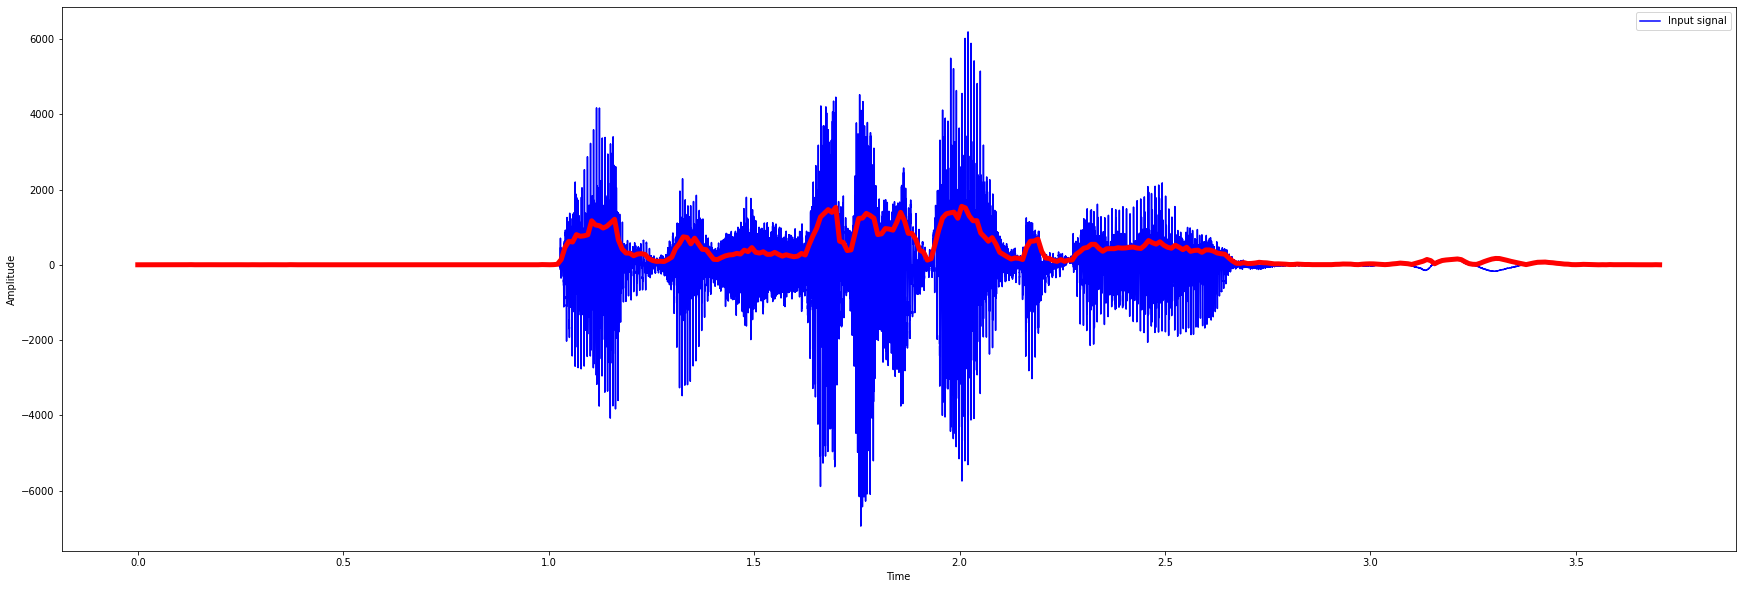

In [5]:
fig = plt.figure("Огибающая графика")
fig.set_figwidth(30)
fig.set_figheight(10)
plt.plot(m_Time, inputData, color="blue", label = 'Input signal')
plt.plot(values, allValues, color="red", linewidth = 5)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

## Фильтрация сигнала.

Для примера возьмём фильтр нижних частот.
$F_d - $ частота дискретизации, $F_s - $ частота среза, $m - $ порядок фильтра. Требуется выслить $wn = 2\frac{F_s}{F_d}$

In [6]:
F_s1 = 400
F_s2 = 900
m = 2
w_n = (2*F_s1/rate, 2*F_s2/rate)
b, a = signal.butter(m, w_n, "bandpass")
data_f = signal.filtfilt(b,a,inputData)

wavfile.write("filtered.wav", rate, data_f.astype(np.int16))

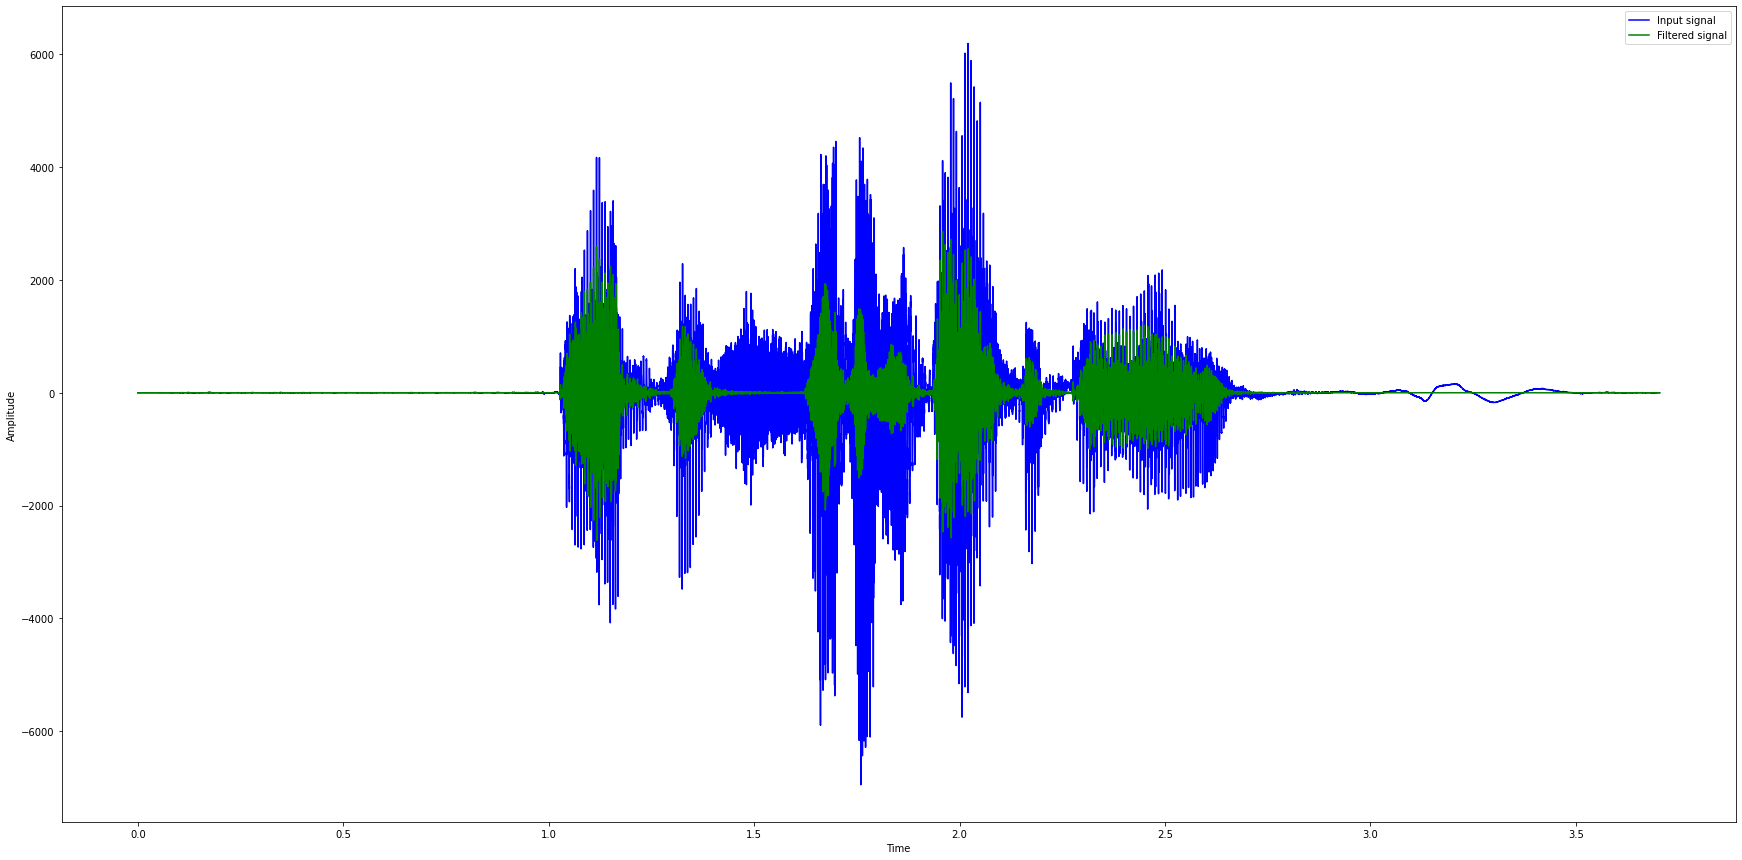

In [7]:
fig = plt.figure()
fig.set_figwidth(30)
fig.set_figheight(15)
plt.plot(m_Time, inputData, color="blue", label = "Input signal")
plt.plot(m_Time, data_f, color="green", label = "Filtered signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


## Детектор сигнал/шум.

Определяем среднее сигнала по амплитуде (без учёта знака): $mid = \frac{1}{N} \displaystyle\sum_{k=0}^{N-1} |x(k)| ~$.
Определяем порог детектора $ Th = \alpha \cdot mid$ , где $ 0<\alpha<1$ подбирается экспериментально. Задаём величину "провала" (в отсчётах) $k$. Обозначим $y(i)$ сигнал после детектирования $ \newline $.
$\bullet $ Событие "начало" сигнала. Если $x(i)$ в течении $k$ отсчётов превышает порог, $y(i) = x(i) \newline $.
$\bullet $ Событие "окончание сигнала". Если $x(i)$ в течении $k$ отсчётов меньше порога, $y(i) = 0$

In [8]:
lenOfSignal = len(inputData)

midSignal = 0
a = 0.5
for i in range(lenOfSignal):
    midSignal += np.abs(inputData[i])
midSignal /= lenOfSignal
th = a * midSignal
k = 10
detector = False
counterIsGood = 0
counterIsBad = 0
resultSignal = np.zeros(lenOfSignal)
for index in range(inputData.shape[0]):
    if detector:
        resultSignal[index] = inputData[index]
    if np.abs(inputData[index]) > th:
        counterIsBad += 1
        counterIsGood = 0
    else:
        counterIsBad = 0
        counterIsGood += 1
    if counterIsBad > k:
        detector = True
    else:
        detector = False
        
wavfile.write("filtered_detector.wav", rate, resultSignal.astype(np.int16))

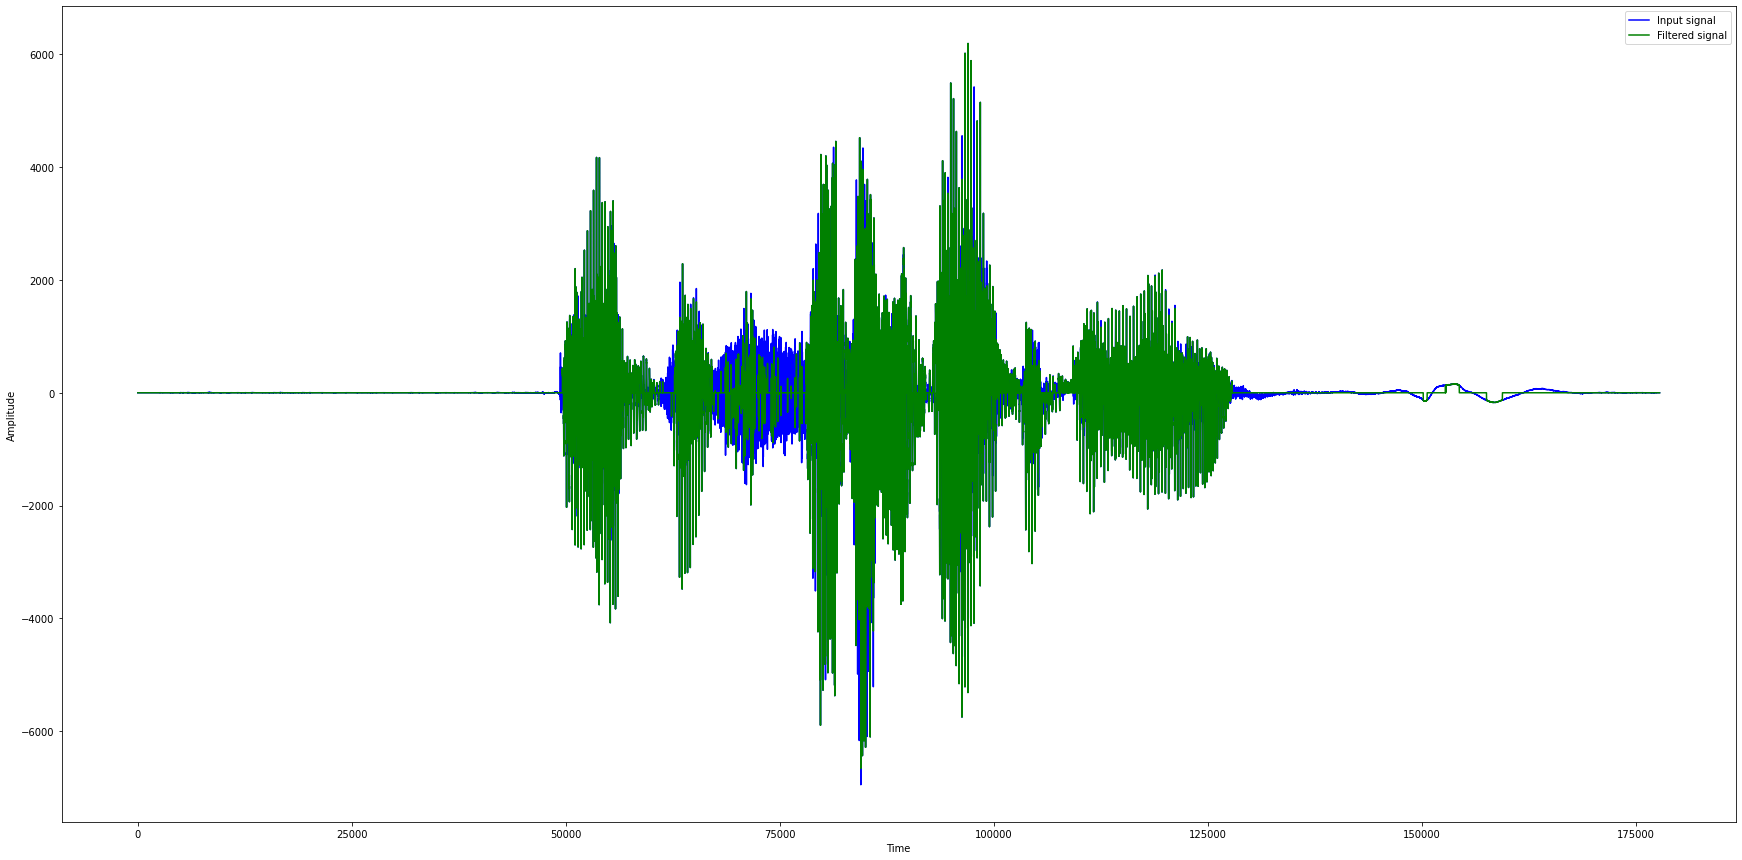

In [9]:
fig = plt.figure("Детектор шума")
fig.set_figwidth(30)
fig.set_figheight(15)
plt.plot(inputData, color="blue", label = "Input signal")
plt.plot(resultSignal, color="green", label = "Filtered signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


## Эффект "Эхо"

Ревербератор реализован, как набор линий задержки. Число линий задержки $N_L > 8 \newline$
Каждая линия задержки имеет свой весовой коэффициент (задается пользователем): $\alpha_1 > \alpha_2 > \dots > \alpha_{N_L} \newline$
Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка.

Желаемое соотношение между "сухим" и обработанным сигналом задается коэффициентом применимости ${\gamma}$.

Ревербератор может работать в двух режимах: ручной и с использованием готовой конфигурации (preset):
$\cdot $ Для ручного режима регулируется пользователем максимальная задержка $D1$, а велечины остальных определяются автоматически через неё: $\\D_i = D_1 \cdot 2^{\frac{1 - i}{N_L}}, i \in [2,N_L]$

$\cdot $ Для готовой конфигурации пользователь вручную задаёт последовательность: $\\ D_1 > D_2 >\dots > D_{N_L} \\ $ 

В данном примере весовые коэффициенты генерируются случайным образом, а задержки определяются по заданной максимальной задережке $D1 = 2400, {\gamma = 0.5}$

In [10]:
lenOfSignal = len(inputData)
m_Time = np.linspace(0, lenOfSignal, inputData.shape[0])
m = int(inputData.shape[0] / n)

In [11]:
F_s = 900
m = 2
w_n = 2*F_s/rate
b, a = signal.butter(m, w_n, 'lowpass')
data_f = signal.filtfilt(b,a,inputData)

In [12]:
D_i = np.zeros(8)
gamma = 0.9
alpha = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
cur = []

max = 0.9
D_i[0] = max

In [13]:
for i in range(1, 8):
    D_i[i] = max * 2**((-i)/8)
for i in range(8):
    newData = alpha[i] * inputData
    cur.append(newData)

echo = np.zeros(int((np.sum(D_i) + len(inputData) / rate + 1) * rate))

for i in range(8):
    cur[i] = signal.filtfilt(b, a, cur[i])
    cur[i] = cur[i] * gamma

for i in range(8):
    if i >= 8:
        D_i += D_i[i-1]
    for j in range(len(cur[i])):
        echo[j + int(D_i[i] * rate)] += cur[i][j]
for i in range(len(inputData)):
    echo[i] += 0.8
for i in range(len(inputData)):
    echo[i] += inputData[i]

In [14]:
wavfile.write("echo.wav", rate, echo.astype(np.int16))

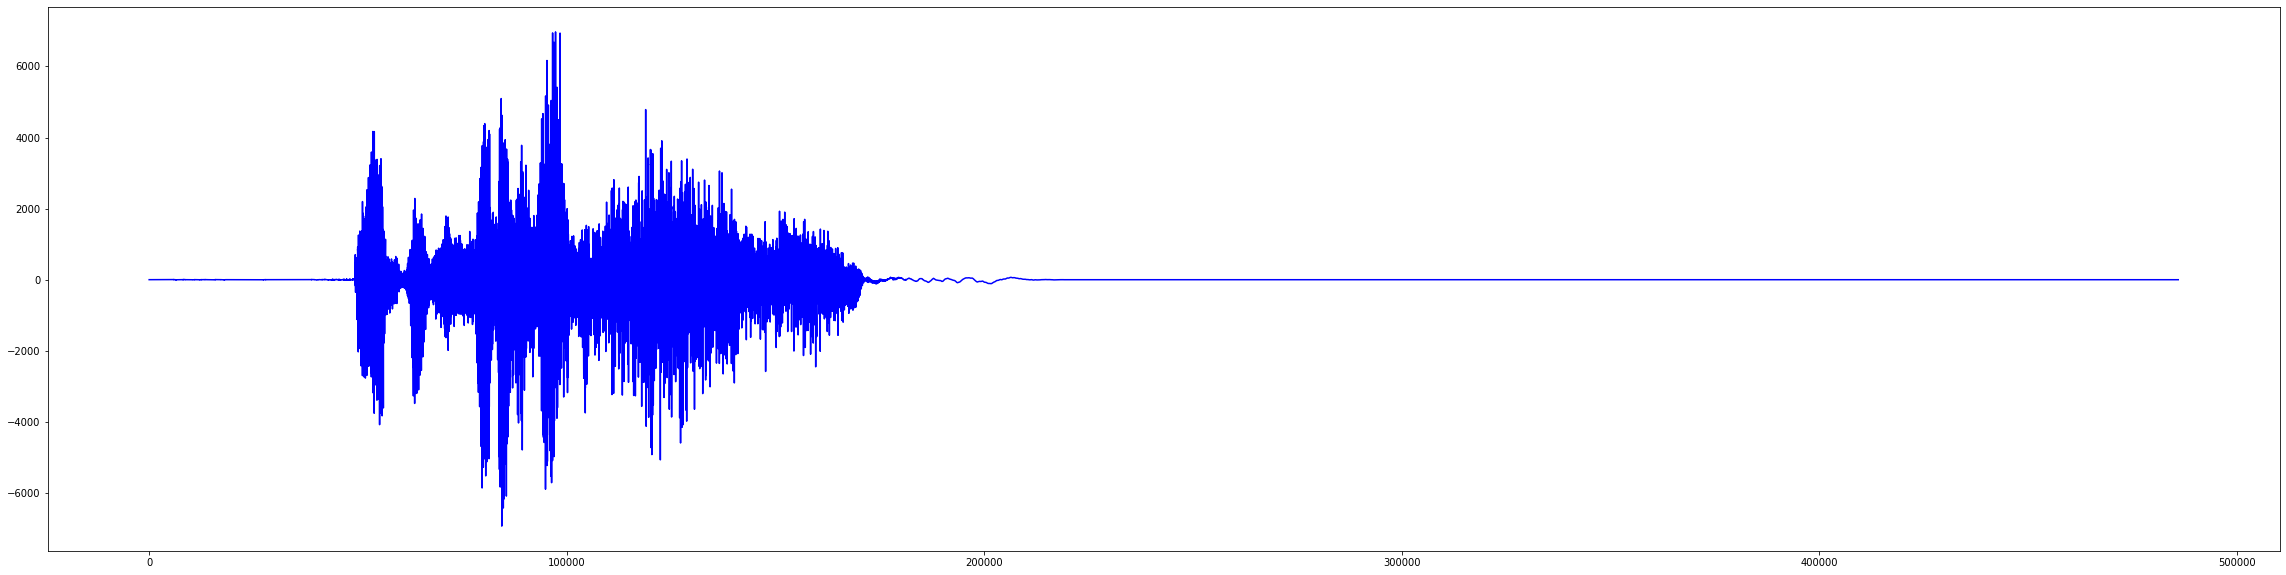

In [15]:
fig = plt.figure()
plt.plot(echo, color="blue")
fig.set_figwidth(40)
fig.set_figheight(10)
plt.show()


## Эффект "Distortion"

Обозначим входной и выходной сигналы, соотвественно как $x(i)$ и $y(i), i \in [0,N-1] \newline$
Пользователь задаёт порог $Th$ и максимальное значение сигнала $max > Th$. Тогда: $\newline$
$Y(i) =
  \begin{cases}
    x(i)       & \quad \text{if } Th \\
    max \cdot sign(x(i))  & \quad \text{if  }  |x(i)| > Th
  \end{cases}$

In [16]:
Th = 250
max = 2000

distortion = np.zeros(lenOfSignal)

for i in range(0, lenOfSignal):
    if abs(inputData[i]) <= Th:
        distortion[i] = inputData[i]
    else:
        distortion[i] = max * np.sign(inputData[i])

wavfile.write("filtered_distortion.wav", rate, distortion.astype(np.int16))


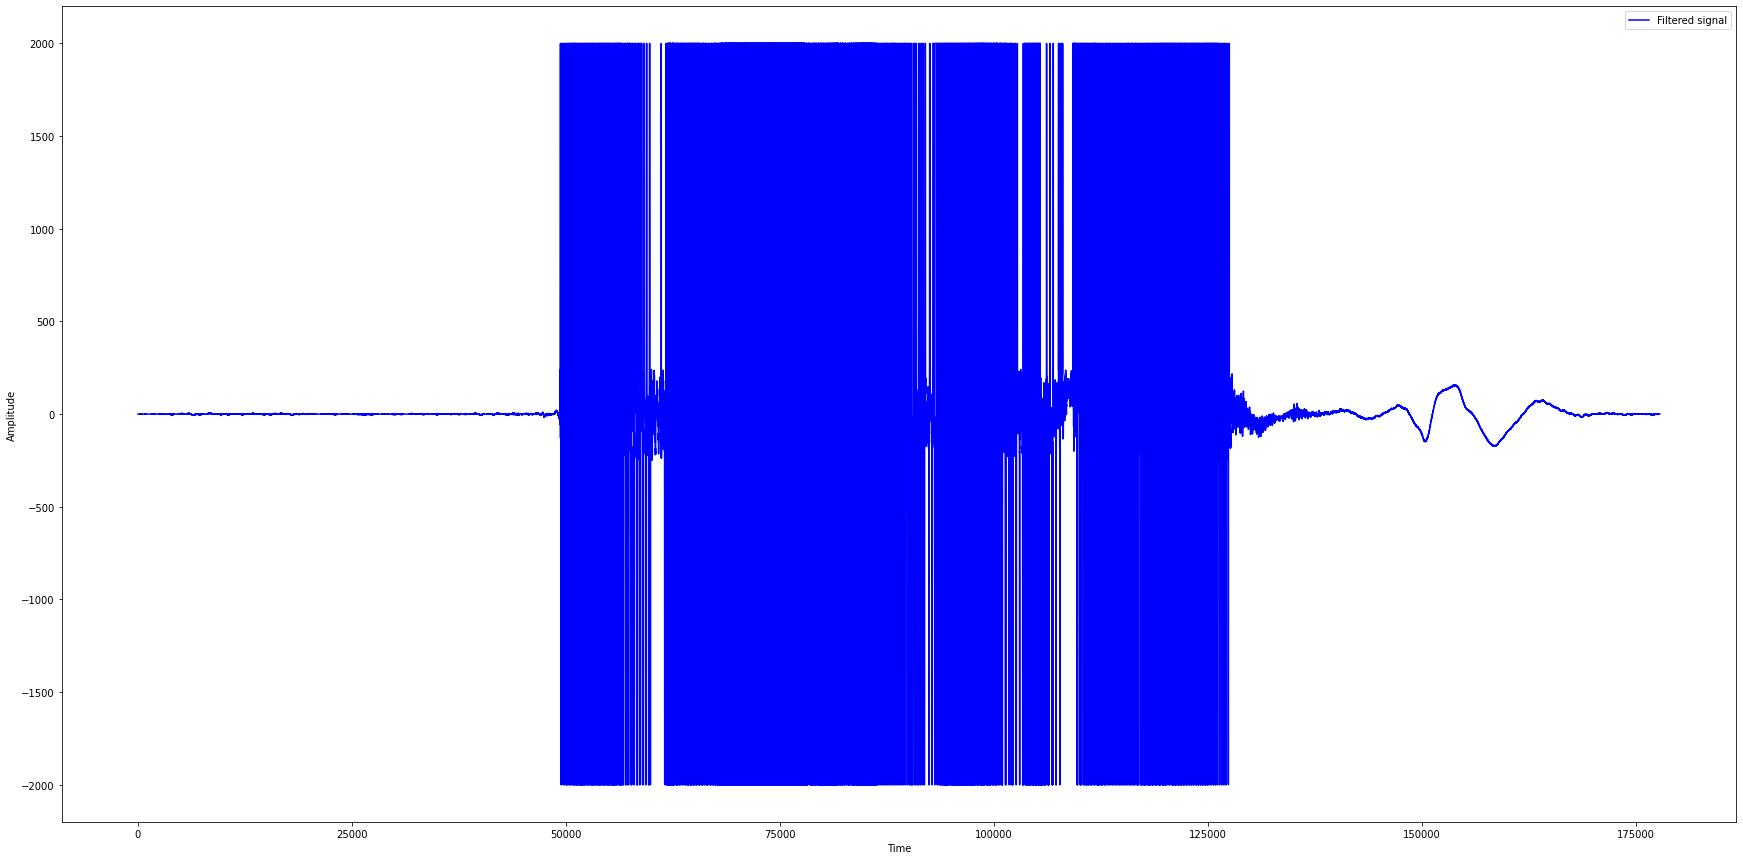

In [17]:
fig = plt.figure("Distortion")
fig.set_figwidth(30)
fig.set_figheight(15)
plt.plot(m_Time,distortion, color="blue", label = "Filtered signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

## Вывод

В ходе выполнения лабораторной работы были изучены возможности библиотек Python для решение задач цифровой обработки сигналов.